In [41]:
import numpy as np
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from scipy import integrate
import scipy.integrate as integrate

In [70]:
data_dl_old = np.array([ 40.53806137,   62.07017585,   61.0243238 , 69.31112943,
                         86.25076898,  101.13069126,  116.81617341,  146.8192414 ,
                        170.23269545,  201.3738048 ,  222.4861474 ,  280.98489615,
                        318.50992938,  405.88497578,  465.31063183,  549.11458077,
                        677.11584355,  768.00310486,  945.15486863, 1117.84857053,
                       1349.22063847, 1578.1307268 , 2001.53401815, 2372.8100645 ,
                       2906.58465084, 3471.22668519, 4242.51098787, 5223.03547744,
                       6480.41734566, 8315.77970426, 9582.15023658])

In [71]:
data_dl = data_dl_old * 67.3 / 73

In [72]:
delta_dl = np.array([   2.72346151,   4.79634547,   2.20603503,   2.30946165,
                        3.39449223,   2.61388012,   3.28521861,   3.83796674,
                        4.45249119,   6.96847286,   9.51854653,   8.03423717,
                        9.66313141,  10.21509654,  12.84279292,   9.4662071 ,
                       12.04078295,  12.26860817,  13.98936404,  16.96826551,
                       19.70873491,  28.53401192,  30.94814492,  45.37042514,
                       52.69970136,  57.46065654, 122.65212034, 131.30859924,
                      199.43646926, 592.06360303, 610.95412592])

In [73]:
data_z = np.array([0.01 , 0.012, 0.014, 0.016, 0.019, 0.023, 0.026, 0.031, 0.037,
                   0.043, 0.051, 0.06 , 0.07 , 0.082, 0.097, 0.114, 0.134, 0.158,
                   0.186, 0.218, 0.257, 0.302, 0.355, 0.418, 0.491, 0.578, 0.679,
                   0.799, 0.94 , 1.105, 1.3  ])

In [74]:
N_obs = len(data_z)

In [75]:
# Define the dimensionality of our problem.
ndim = 2

#[]{}
            
def loglike(x):
    """The log-likelihood function."""    
    c = 3e5
    H0, omega = x

    func = 1/(np.sqrt(omega*((data_z+1)**3)+1-omega))
    
    integ = integrate.cumtrapz(func, data_z, initial = 0) 
    
    init_point = 0.5*0.01*(func[0] + 1)
    first_term = -(N_obs/2) * np.log(2 * np.pi) - np.log(np.prod(delta_dl))
    second_term = -np.sum((1/(2 * delta_dl**2)) * (data_dl - ((c/H0)*((1+data_z)*(integ + init_point))))**2)
    

    return(first_term + second_term)
 

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

#    return 100. * (2. * u - 1.)
    H0prime, omegaprime = u
    
#    H0 = 100. * (H0prime)
#    omega = 10. * (2. * omegaprime - 1.)

    H0min = 0.
    H0max = 100.0

    omegamin = 0.0
    omegamax = 10.0
    
    H0 = H0prime * (H0max - H0min) + H0min
    omega = omegaprime * (omegamax - omegamin) + omegamin
    
    return(H0, omega)    

In [76]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=1500)
sampler.run_nested()
sresults = sampler.results

14561it [00:11, 1303.85it/s, +1500 | bound: 8 | nc: 1 | ncall: 72439 | eff(%): 22.641 | loglstar:   -inf < -126.827 <    inf | logz: -136.651 +/-  0.077 | dlogz:  0.001 >  1.509]


In [77]:
# "Dynamic" nested sampling.
dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresults = dsampler.results

16183it [00:12, 1344.56it/s, batch: 8 | bound: 3 | nc: 1 | ncall: 39992 | eff(%): 40.365 | loglstar: -131.510 < -126.827 < -127.442 | logz: -136.578 +/-  0.076 | stop:  0.919]        


In [78]:
# Combine results from "Static" and "Dynamic" runs.
results = dyfunc.merge_runs([sresults, dresults])

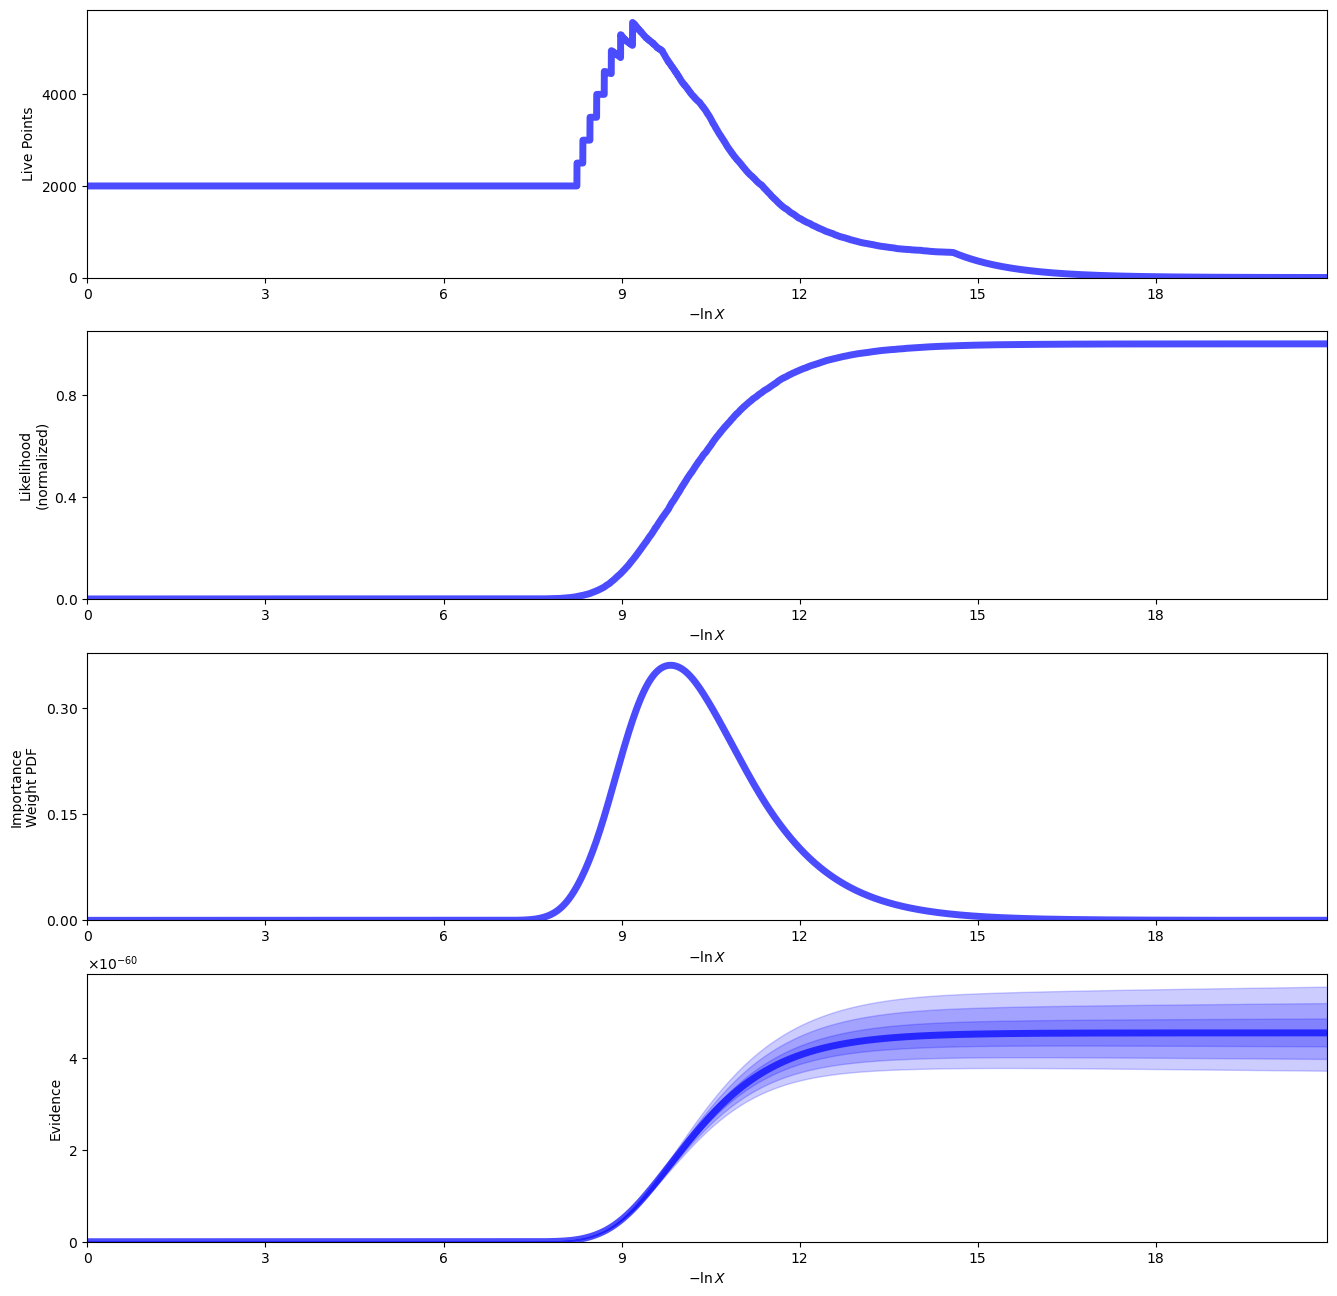

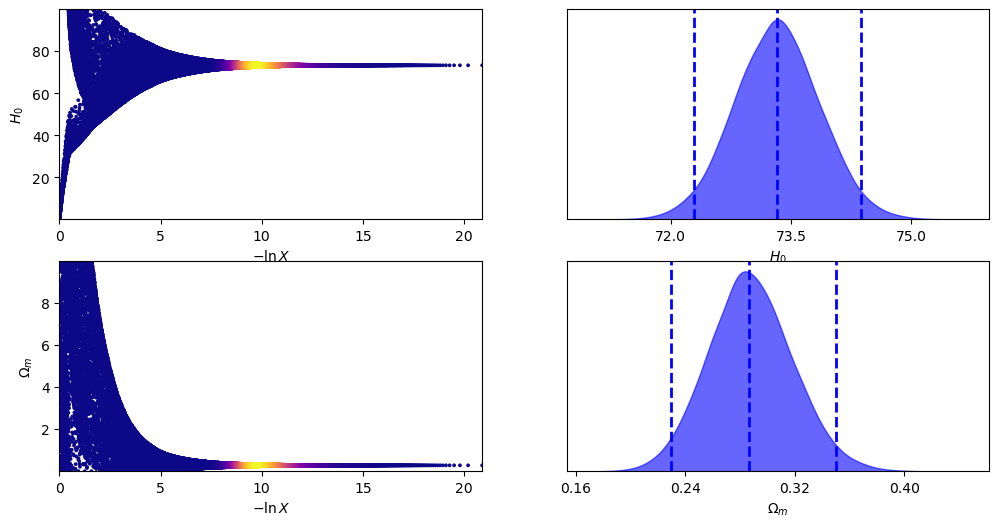

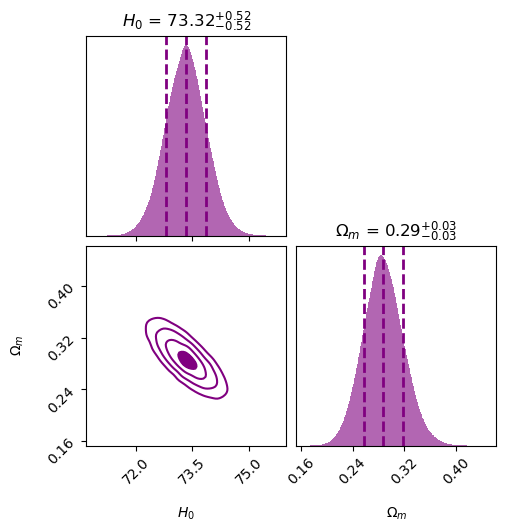

In [83]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results, labels=[r"$H_0$", r"$\Omega_m$"])

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results, color = 'purple', labels=[r"$H_0$", r"$\Omega_m$"] , show_titles=True, quantiles=[0.16, 0.5, 0.84], title_quantiles=[0.16, 0.5, 0.84])